In [1]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

<module 'galaxy_survey' from '/home/yanlong/Documents/galaxy_survey/galaxy_survey.cpython-38-x86_64-linux-gnu.so'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

## Debug camb_cosmology

In [3]:
cm = gc.camb_cosmology()

In [4]:
cm.rstar

98.07868989476889

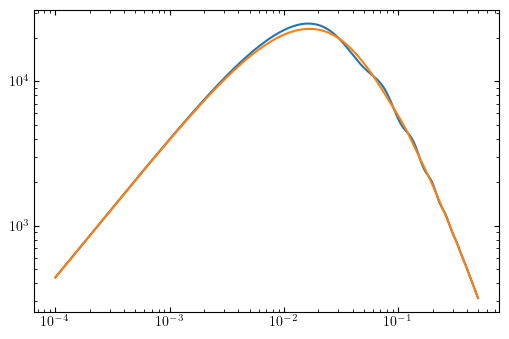

In [5]:
kh = np.linspace(0.0001, .5, num=1000)
plt.loglog(kh, [cm.matter_power_spectrum(x) for x in kh])
plt.loglog(kh, [cm.matter_power_spectrum_no_wiggle(x) for x in kh])

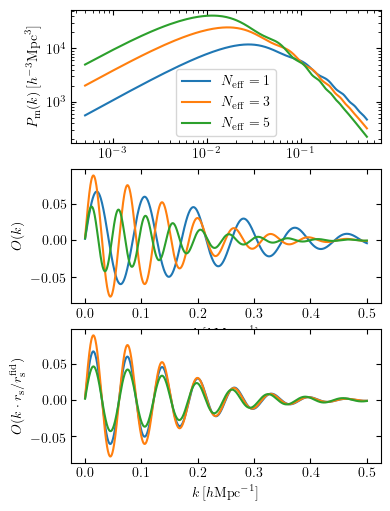

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(4, 6))

kh = np.linspace(0.0005, .5, num=1000)

p = {'nnu':{'value':3}}
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3
for nnu in [1, 3, 5]:
    p['nnu']['value'] = nnu
    cm = gc.camb_cosmology(p, p0)
    alpha = cm.alpha
    axs[0].loglog(kh, [cm.matter_power_spectrum(x) for x in kh], label=r'$N_{\rm eff}=%.0f$'%nnu)
    axs[0].set_ylabel(r'$P_{\rm m}(k)\,[h^{-3}{\rm Mpc}^3]$')
    axs[0].legend()
    
    axs[1].plot(kh, [cm.oscillation_part(x) for x in kh])
    axs[1].set_ylabel(r'$O(k)$')
    axs[1].set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$')
    
    axs[2].plot(kh, [cm.oscillation_part(x*alpha) for x in kh])
    axs[2].set_ylabel(r'$O(k\cdot r_{\rm s}/r_{\rm s}^{\rm fid})$')
    axs[2].set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$')
    
plt.savefig('neutrino_effect_ps.pdf', bbox_inches='tight')

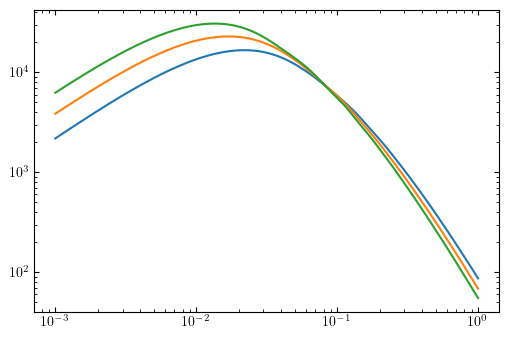

In [17]:
kh = np.logspace(-3, 0, num=1000)

p = {'nnu':{'value':3}}
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3
for nnu in [2, 3, 4]:
    p['nnu']['value'] = nnu
    cm = gc.camb_cosmology(p, p0)
    alpha = cm.alpha
    q = cm.q_isotropic(0.001)
    plt.loglog(kh, [cm.matter_power_spectrum_no_wiggle(x/q)/q**3 for x in kh])

1.0000014137083975 0.9982445162013821 0.9982459274280374 1.000001059073777 1.0000021229869844
1.0000047688141642 0.9938775638673739 0.993882303484778 1.0000035724545557 1.000007161639738
1.000009398640242 0.9878630603466079 0.9878723449161205 1.0000070405379147 1.0000141152580733


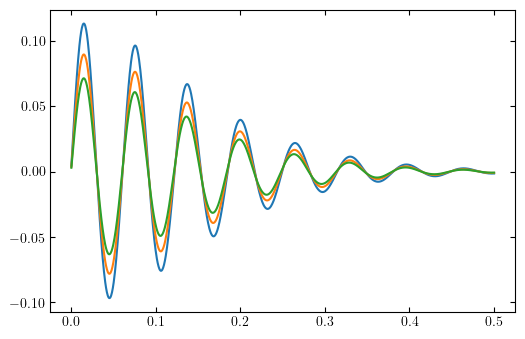

In [18]:
anu = 7/8 *(4/11)**(4/3)
anu = 1/anu
def set_omch2(nnu, ombh2, omch2):
    return (anu+nnu)/(anu+3.046)*(ombh2+omch2)-ombh2

kh = np.linspace(0.0005, .5, num=1000)

p = {'nnu':{'value':3},
     'ombh2': {'value': 0.0223, 'stdev': 0.00015, 'h': 0.0008},
     'omch2': {'value': 0.1188, 'stdev': 0.0012, 'h': 0.001},}
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3
for nnu in [2, 3, 4]:
    p['nnu']['value'] = nnu
    p['omch2']['value'] = set_omch2(nnu, p0['ombh2']['value'], p0['omch2']['value'])
    cm = gc.camb_cosmology(p, p0)
    alpha = cm.alpha
    q = cm.q_isotropic(0.001)
    qv = cm.q_vertical(0.001)
    qp = cm.q_parallel(0.001)
    print(q, alpha, q*alpha, qv, qp)
    plt.plot(kh, [cm.oscillation_part(x*alpha) for x in kh])

In [4]:
%timeit cm.matter_power_spectrum_no_wiggle(0.5)

95.6 ns ± 0.938 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [5]:
%timeit cm.matter_power_spectrum(0.5)

93.4 ns ± 0.22 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [6]:
cm.matter_power_spectrum.cache_info()

CacheInfo(hits=81111110, misses=1000001, maxsize=None, currsize=1000001)

In [7]:
%timeit cm.oscillation_part(0.5)

95 ns ± 0.33 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [8]:
%timeit cm.q_isotropic(0.5)

93.1 ns ± 0.151 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


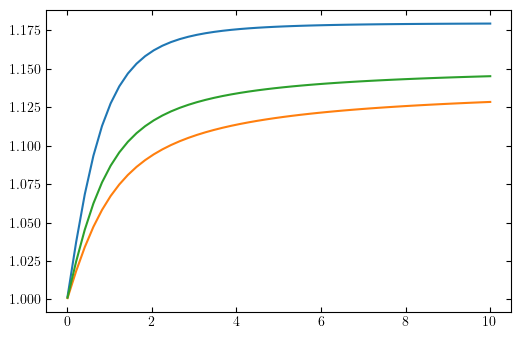

In [43]:
p['nnu']['value'] = 4
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3
cm = gc.camb_cosmology(p, p0)
for q in cm.get_ap_factors():
    zs = np.linspace(0.01, 10)
    plt.plot(zs, [q(x) for x in zs])

In [31]:
pp = cm.power_spectrum_derivative_parts_factory({'nnu':{'value':2}}, {'nnu':{'value':4}}, 1)

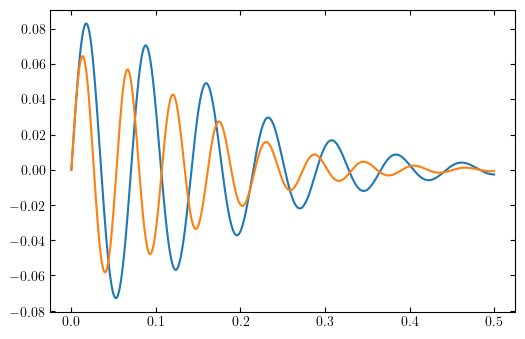

In [32]:
kh = np.linspace(0.0001, .5, num=1000)
for key in ['plus', 'minus']:
    plt.plot(kh, [pp[key]['oscillation_part'](x) for x in kh])

In [18]:
cm.prepare_power_spectrum_derivative_parts(['ombh2', 'nnu'])

In [20]:
cm.power_spectrum_derivative_parts

{'ombh2': {'plus': {'matter_power_spectrum': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'matter_power_spectrum_no_wiggle': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'oscillation_part': <function galaxy_correlations.camb_cosmology.get_power_spectrum.<locals>.<lambda>(x)>,
   'q_parallel': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>,
   'q_vertical': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>,
   'q_isotropic': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>},
  'minus': {'matter_power_spectrum': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'matter_power_spectrum_no_wiggle': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'oscillation_part': <function galaxy_correlations.camb_cosmology.get_power_spectrum.<locals>.<lambda>(x)>,
   'q_parallel': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>,
   'q_vertical':

## Debug galaxy_survey PS

In [1]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)
import fisher_matrix as fm
reload(fm)

<module 'fisher_matrix' from 'C:\\Users\\yanlo\\Dropbox\\galaxy_survey\\fisher_matrix.py'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

In [3]:
cp = {'nnu':{'value':3.046}}
fcp = {'nnu':{'value':3.046}}

In [4]:
#svy = gs.survey(cosmological_parameters=cp, fiducial_cosmological_parameters=fcp)
svy = gs.survey()
svy.update_survey_setups()

In [5]:
svy0 = gs.survey(cosmological_parameters=cp, fiducial_cosmological_parameters=fcp, cosmological_parameters_in_fisher=[])
svy0.update_survey_setups()

In [6]:
%timeit svy.integrand_bs((.1,.1,.1,0,0),0)
#%timeit svy.integrand_ps(0.4, 0, 0)

1.56 ms ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


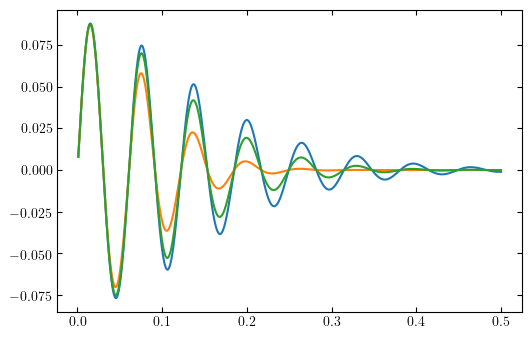

In [7]:
kh = np.linspace(0.001, .5, num=1000)
plt.plot(kh, [svy.oscillation_part(x, damp=False) for x in kh])
plt.plot(kh, [svy.oscillation_part(x, damp=True) for x in kh])
plt.plot(kh, [svy.oscillation_part(x, damp=True, reconstruction=True) for x in kh])

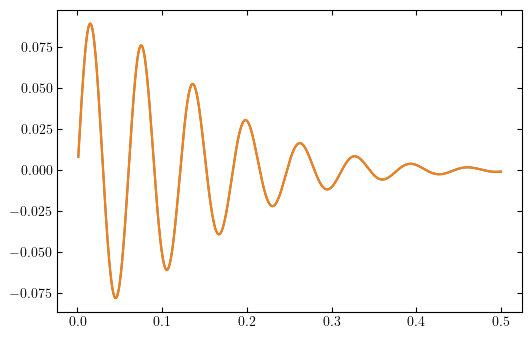

In [8]:
kh = np.linspace(0.001, .5, num=1000)
plt.plot(kh, [svy0.oscillation_part(x) for x in kh])
plt.plot(kh, [svy.oscillation_part(x, fix_rstar=True, ap_effect=False) for x in kh])

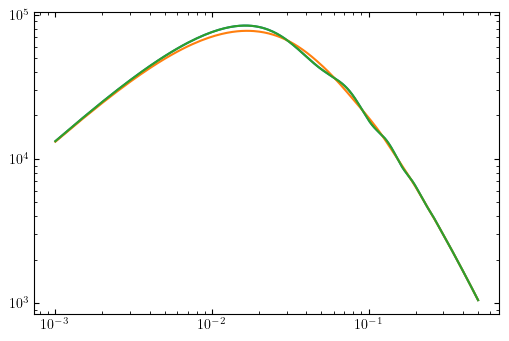

In [9]:
kh = np.linspace(0.001, .5, num=1000)
mu, z = 1, 1
plt.loglog(kh, [svy.power_spectrum(x, mu, z) for x in kh])
plt.loglog(kh, [svy.power_spectrum(x, mu, z, no_wiggle=True) for x in kh])
plt.loglog(kh, [svy.power_spectrum(x, mu, z, debug=True, rsd=True, bias=True, noise=True, damp=True, ap_effect=True, reconstruction=True) for x in kh])

2.1308257683621523

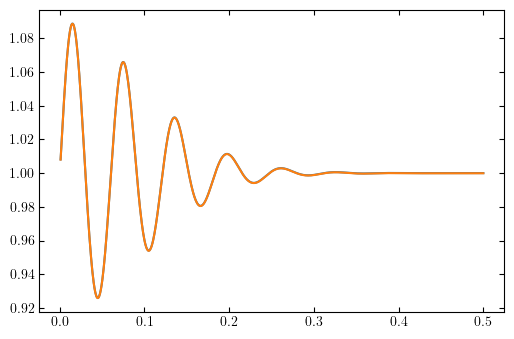

In [10]:
kh = np.linspace(0.001, .5, num=1000)
mu, z = 1, 0
plt.plot(kh, [svy.power_spectrum(x, mu, z)/svy.power_spectrum(x, mu, z, no_wiggle=True) for x in kh])
plt.plot(kh, [svy.power_spectrum(x, mu, z, matter_only=True, external_ps_parts=(lambda x: 1.0, svy.camb_cosmology.oscillation_part, 
            svy.camb_cosmology.q_parallel, svy.camb_cosmology.q_vertical, svy.camb_cosmology.q_isotropic)) for x in kh])

svy.rsd_factor_z1(z, mu, rsd=True, bias=True)**2

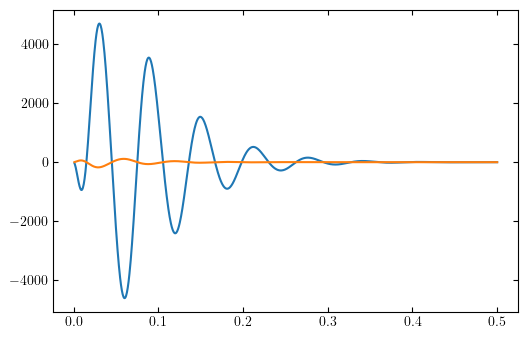

In [11]:
kh = np.linspace(0.001, .5, num=1000)
dos = np.array([svy.power_spectrum_derivative_analytical(x) for x in kh])
plt.plot(kh, dos[:,0])
plt.plot(kh, dos[:,1])

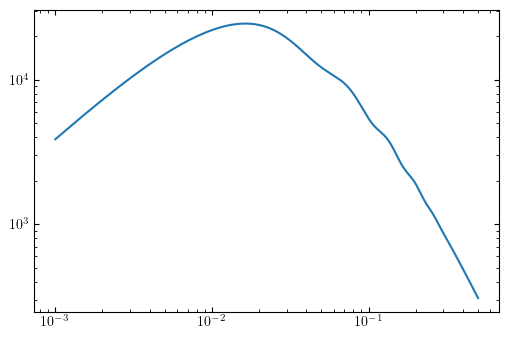

In [12]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.power_spectrum_derivative_bias(x)[0] for x in kh])
plt.loglog(kh, dps)

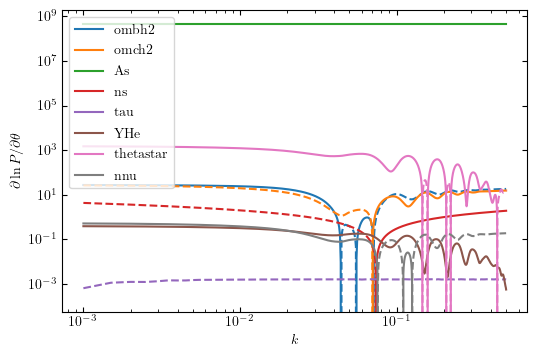

In [13]:
kh = np.linspace(0.001, .5, num=1000)
z=0
dps = np.array([np.array(svy.power_spectrum_derivative_cosmological_parameters(x, z=z))/svy.power_spectrum(x, z=z) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.loglog(kh, dps[:,i], label=l)
    plt.loglog(kh, -dps[:,i], c=pl[0].get_color(), ls='--')
    
plt.ylabel(r'$\partial \ln P/\partial \theta$')
plt.xlabel('$k$')
plt.legend()

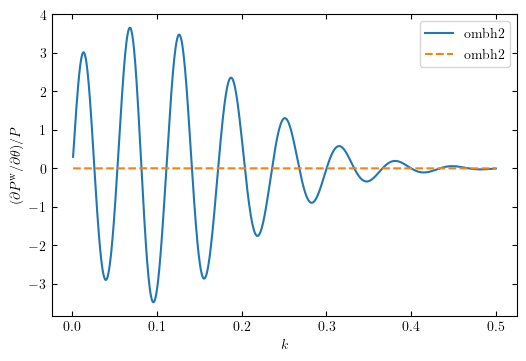

In [14]:
kh = np.linspace(0.001, .5, num=1000)
z=2
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, wiggle_only=True)\
                /svy.power_spectrum(x, z=z, no_wiggle=True) for x in kh])
for i, l in zip(range(1), ['ombh2']):
    2333
    pl = plt.plot(kh, dps[:,i], label=l)
    
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, wiggle_only=False, phase_only=True)\
                /svy.power_spectrum(x, z=z, no_wiggle=True) for x in kh])
for i, l in zip(range(1), ['ombh2']):
    pl = plt.plot(kh, dps[:,i], label=l, ls='--')

plt.ylabel(r'$(\partial P^{\rm w}/\partial \theta)/P$')
plt.xlabel('$k$')
plt.legend()

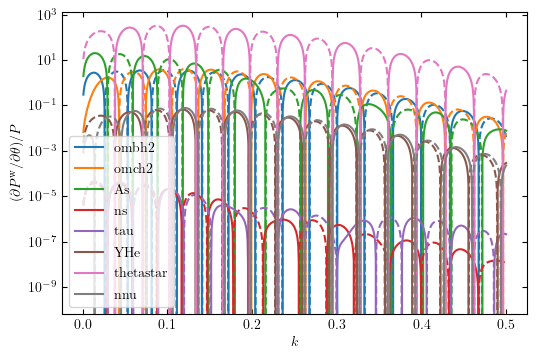

In [15]:
kh = np.linspace(0.001, .5, num=1000)
z=0
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, wiggle_only=True)/svy.power_spectrum(x, z=z) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.semilogy(kh, dps[:,i], label=l)
    plt.plot(kh, -dps[:,i], c=pl[0].get_color(), ls='--')

plt.ylabel(r'$(\partial P^{\rm w}/\partial \theta)/P$')
plt.xlabel('$k$')
plt.legend()

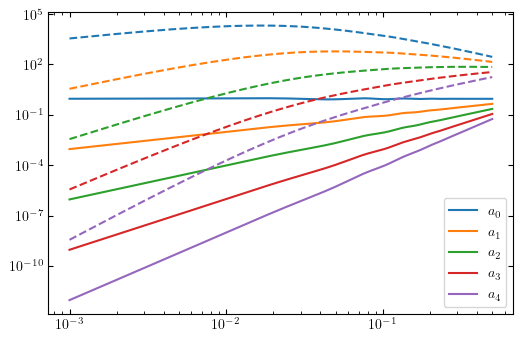

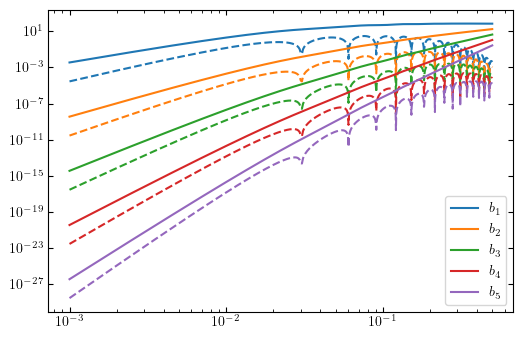

In [16]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.power_spectrum_derivative_polynomial(x) for x in kh])
dpws = np.array([svy.power_spectrum_derivative_polynomial(x, wiggle_only=True) for x in kh])
a = svy.polynomial_parameters['a']
b = svy.polynomial_parameters['b']
for i, l in zip(range(len(a)), a):
    pl = plt.loglog(kh, dps[:,i], label='$a_{%d}$'%l)
    plt.loglog(kh, dpws[:,i], ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

for i, l in zip(range(len(a), len(a)+len(b)), b):
    pl = plt.loglog(kh, dps[:,i], label='$b_{%d}$'%l)
    plt.loglog(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

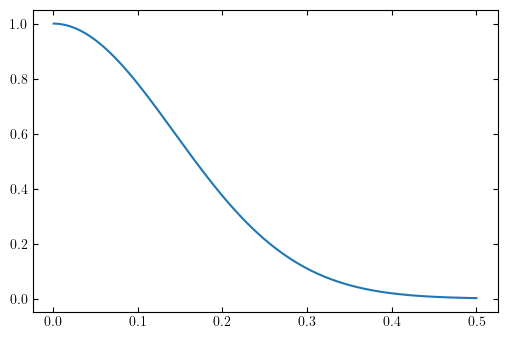

In [165]:
kh = np.linspace(0.001, .5, num=1000)
mu, z = 1, 2
dps = np.array([svy.power_spectrum(x, mu, z, no_wiggle=False, matter_only=False) for x in kh])
dpnws = np.array([svy.power_spectrum(x, mu, z, no_wiggle=True, matter_only=False) for x in kh])
damps = np.array([svy.damping_factor(x, mu, z, damp=True, reconstruction=True) for x in kh])
plt.plot(kh, damps)

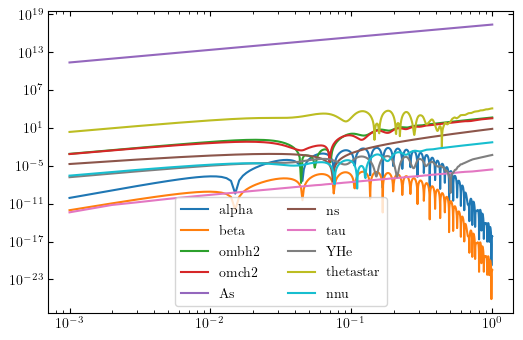

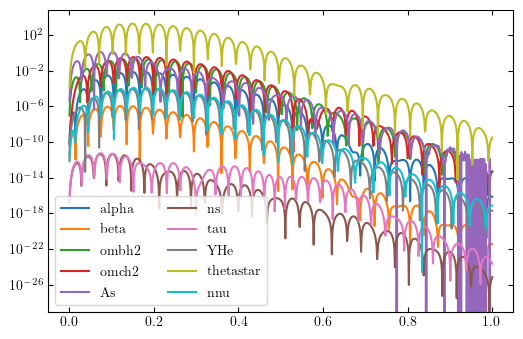

In [17]:
kh = np.linspace(0.001, 1, num=1000)

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_ps(x, 0, 0)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_ps(x, 0, 0, wiggle_only=True)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

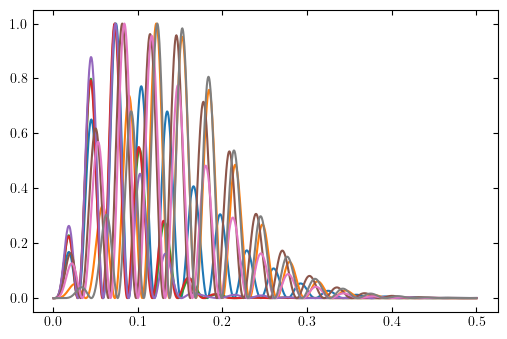

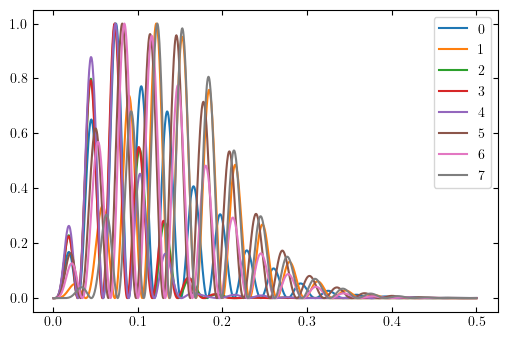

In [45]:
kh = np.linspace(0.001, .5, num=1000)

mu, z = 0, 2

for i in range(2, 10):
    dp = np.array([svy.integrand_ps(x, mu, z, wiggle_only=True)[i, i] for x in kh])
    pl = plt.plot(kh, dp/dp.max())
plt.show()

for j in range(8):
    dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, mu, z, wiggle_only=True) for x in kh])
    ps = np.array([svy.power_spectrum(x, mu, z) for x in kh])
    ts = dps[:,j]**2/ps**2*kh**2
    plt.plot(kh, ts/ts.max(), label='%d'%j)
plt.legend()
plt.show()

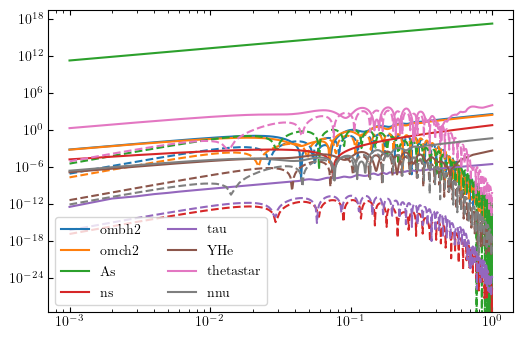

In [28]:
kh = np.linspace(0.001, 1, num=1000)

for i, l in zip(range(2, 10), svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_ps(x, 0, 0)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
    dp = [svy.integrand_ps(x, 0, 0, wiggle_only=True)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, ls='--', c=pl[0].get_color())    
plt.legend(ncol=2)
plt.show()

In [152]:
for x in [False, True]:
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x)
    print(fs.constraints()[1]['nnu'], fs.constraints()[1]['beta'])

0.31526770793459724 0.19369473063693832
15.419748826051505 0.2959826021596305


In [15]:
for x in [False, True]:
    svy.update_survey_setups(ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fishe', 'polynomial_in_fishe', 'ap_effect', 'shot_noise', 'reconstruction'])
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x)
    print(fs.constraints()[1]['nnu'], fs.constraints()[1]['beta'])

0.08086770095342939 0.1256643005594318
9.704198613321935 0.22350719377526054


In [72]:
def sb2sn(x):
    return 1/0.194057*x
def sn2sb(y):
    return 0.194057*y

In [17]:
import h5py
for x in [False, True]:
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x)
    with h5py.File('planck_cmb_fisher.hdf5', 'r') as cf:
        cmb_fisher = fm.read_hdf5(cf)
    sb = fs.slice(['nnu', 'thetastar'], exclude=True).merge(cmb_fisher).constraints()[1]['beta']
    print(sb, sb2sn(sb))

0.009954393127613077 0.05129623320783624
0.01664502210572712 0.08577388141487872


In [18]:
for x in [False, True]:
    svy.update_survey_setups(ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fisher', 'polynomial_in_fisher', 'ap_effect', 'shot_noise', 'reconstruction'])
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x).slice(['alpha', 'beta'], exclude=True)
    fs.matrix = fs.matrix
    with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
        cmb_fisher = fm.read_hdf5(cf)
    sn = fs.merge(cmb_fisher).slice(['YHe'], exclude=True).constraints()[1]['nnu']
    print(sn)

0.014871077266374596
0.03451123372070868


In [63]:
ndesi = np.loadtxt('desi-density.txt')
ndesi[:,1]/=1e3
sky_deg = 4*np.pi*(180/np.pi)**2
desi_geo = {
    'f_sky': 14000/sky_deg,
    'ng_z_list': ndesi,
    'dz': 0.1,
    'Sigma_0': 16.6,
    'b_0': 0.95,
    'survey_type':'spectroscopic',
    'sigma8_0': 0.9,
}

In [64]:
svy.update_survey_setups(desi_geo, polynomial_parameters={'a': [], 'b': [1, ]})

In [50]:
for x in [True, False]:
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x, regions=[{'k_min': 0.01,'k_max': 0.5,'mu_min': -1.0,'mu_max': 1.0}])
    fs = fs.slice(['alpha', 'beta'], exclude=True)
    with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
        cmb_fisher = fm.read_hdf5(cf)
    sn = fs.merge(cmb_fisher).slice(['YHe'], exclude=True).constraints()[1]['nnu']
    print(sn)

0.09576190122613
0.03967311168932633


In [ ]:
import h5py
import defaults as df

dfs = df.defaults()
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid,]
#surveys = [dfs.boss, dfs.desi]

with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)

ks = np.linspace(0.011, 0.3, num=41)

with h5py.File("ps_kamx_dependence.hdf5", "w") as f:
    f.create_dataset('kmaxs', data=ks)
    for survey in surveys:
        key_svy = survey['short_name']
        print(key_svy)
        if key_svy not in list(f.keys()):
            group_svy = f.create_group(key_svy)
        else:
            group_svy = f[key_svy]
        
        sns = []
        for k in tqdm(ks):
            temp = []
            for x in [False, True]:
                if x:
                    pp = {'a': [0,1,2,3,4], 'b' :[1,2,3]}
                else:
                    pp = {'a': [], 'b' :[1]}
                svy.update_survey_setups(survey_geometrics=survey, polynomial_parameters=pp,
                                        ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fisher', 'polynomial_in_fisher', 'ap_effect', 'shot_noise'],
                                        )
                fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x, 
                                                          div_k = int(max((k-0.01)//0.005, 2)),
                                                          div_mu = 20,
                                                          regions=[{'k_min': 0.01,'k_max': k,'mu_min': -1.0,'mu_max': 1.0}])
                fs = fs.slice(['poly', 'bias'], fuzzy_filter=True, exclude=True)
                sn = fs.merge(cmb_fisher).slice(['YHe', 'alpha', 'beta'], exclude=True).constraints()[1]['nnu']
                temp.append(sn)
                sn = fs.merge(cmb_fisher).slice(['alpha', 'beta'], exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        group_svy.create_dataset('sns', data=sns)

boss


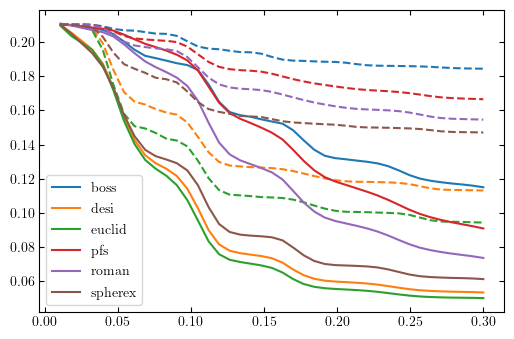

In [31]:
with h5py.File("ps_kamx_dependence.hdf5", 'r') as f:
    kmaxs = f['kmaxs']
    for svy_key in f.keys():
        if svy_key == 'cvl' or svy_key =='kmaxs':
            continue
        sns = f[svy_key]['sns'][()]
        #print(sns)
        pl = plt.plot(kmaxs, sns[:,0], label=svy_key)
        plt.plot(kmaxs, sns[:,2], ls='--', c=pl[0].get_color())
    plt.legend()
    plt.show()

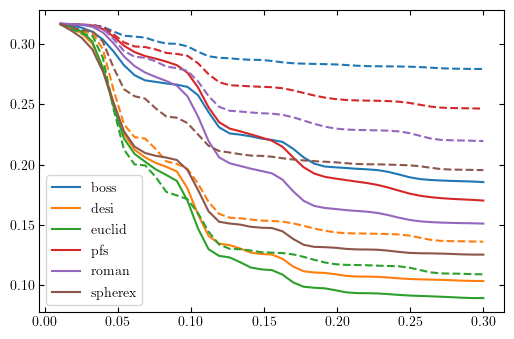

In [32]:
with h5py.File("ps_kamx_dependence.hdf5", 'r') as f:
    kmaxs = f['kmaxs']
    for svy_key in f.keys():
        if svy_key == 'kmaxs' or svy_key == 'cvl':
            continue
        sns = f[svy_key]['sns'][()]
        pl = plt.plot(kmaxs, sns[:,1], label=svy_key)
        plt.plot(kmaxs, sns[:,3], ls='--', c=pl[0].get_color())
    plt.legend()
    plt.show()

In [49]:
import h5py
import defaults as df

dfs = df.defaults()
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid,]
surveys = [dfs.boss]

with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)

ks = np.linspace(0.02, 0.5, num=11)


for survey in surveys:

    sns = []
    for k in tqdm(ks):
        temp = []
        for pp in [{'a': [], 'b' :[]},
                   {'a': [], 'b' :[1, 2]},
                   {'a': [0, 1, 2, 3, 4], 'b' :[1]},
                   {'a': [0,], 'b' :[]},
                   {'a': [0, 1, 2], 'b' :[1]},
                   {'a': [0, 1, 2, 3, 4], 'b': [1, 2, 3, 4, 5]}
                  ]:
            svy.update_survey_setups(survey_geometrics=survey, polynomial_parameters=pp)
            for x in [False, True]:
                fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x, regions=[{'k_min': 0.01,'k_max': k,'mu_min': -1.0,'mu_max': 1.0}])
                sn = fs.merge(cmb_fisher).slice(['YHe', 'alpha', 'beta'], exclude=True).constraints()[1]['nnu']
                temp.append(sn)
                sn = fs.merge(cmb_fisher).slice(['alpha', 'beta'], exclude=True).constraints()[1]['nnu']
                temp.append(sn)
        sns.append(temp)

  0%|          | 0/11 [00:00<?, ?it/s]

/home/yanlong/Documents/galaxy_survey/fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


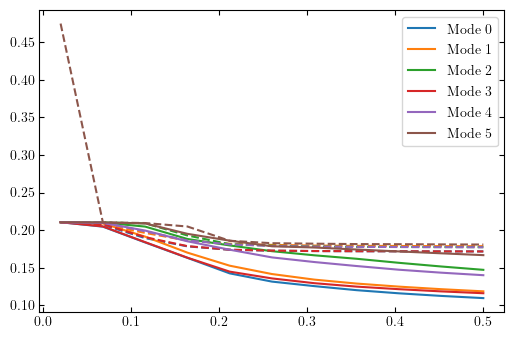

In [50]:
sns = np.array(sns)
for i in range(6):
    pl = plt.plot(ks, sns[:,i*4], label='Mode %d'%i)
    plt.plot(ks, sns[:,i*4+2], ls='--', c=pl[0].get_color())
plt.legend()

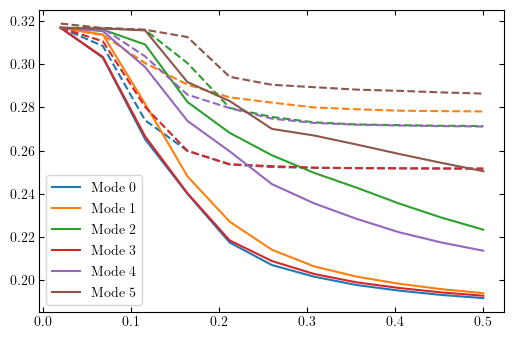

In [51]:
sns = np.array(sns)
for i in range(6):
    pl = plt.plot(ks, sns[:,i*4+1], label='Mode %d'%i)
    plt.plot(ks, sns[:,i*4+3], ls='--', c=pl[0].get_color())
plt.legend()

## Debug galaxy_survey BS

In [4]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

import fisher_matrix as fm

In [5]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

In [6]:
svy = gs.survey()

In [7]:
svy.update_survey_setups()

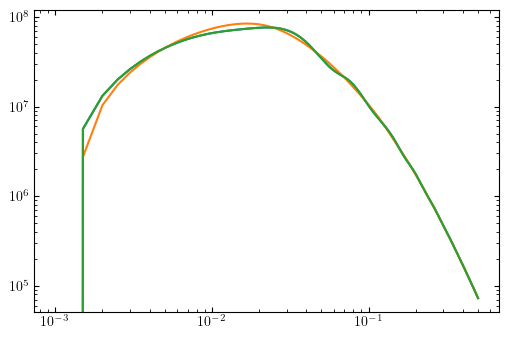

In [8]:
kh = np.linspace(0.001, .5, num=1000)
plt.loglog(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18') for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', no_wiggle=True) for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', reconstruction=True) for x in kh])

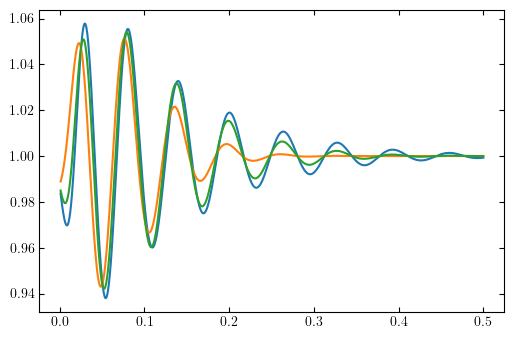

In [9]:
kh = np.linspace(0.001, .5, num=1000)
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True)
              /svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, no_wiggle=True) for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, damp=True, reconstruction=False)
              /svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, no_wiggle=True) for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, damp=True, reconstruction=True)
              /svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, no_wiggle=True) for x in kh])

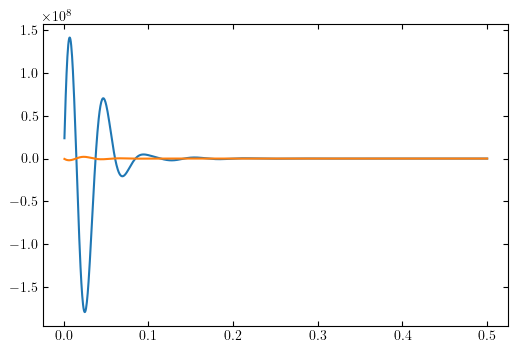

In [10]:
kh = np.linspace(0.001, .5, num=1000)
dos = np.array([svy.bispectrum_derivative_analytical((x, 0.1, 1), coordinate='child18',) for x in kh])
plt.plot(kh, dos[:,0])
plt.plot(kh, dos[:,1])

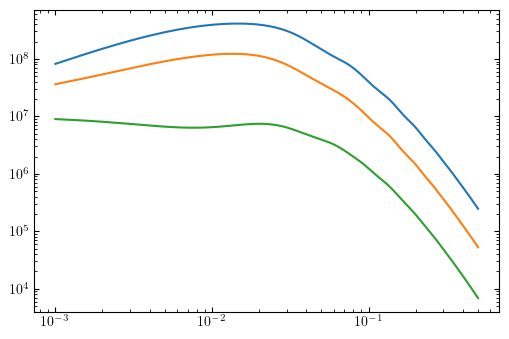

In [11]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_bias((x, 0.1, 1), coordinate='child18',) for x in kh])
plt.loglog(kh, dps[:,0])
plt.loglog(kh, dps[:,1])
plt.loglog(kh, dps[:,2])

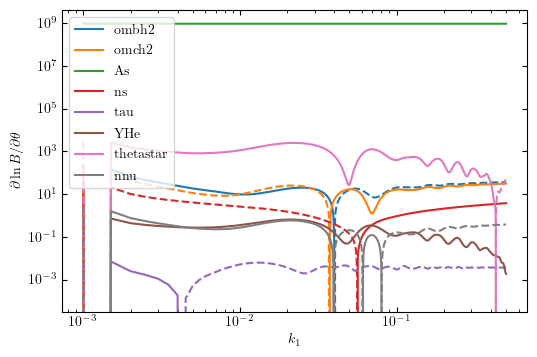

In [12]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_cosmological_parameters((x, 0.1, 1), coordinate='child18',)\
                /svy.bispectrum((x, 0.1, 1), coordinate='child18',) for x in kh])
for i, l in zip(range(len(svy.cosmological_parameters_in_fisher)), svy.cosmological_parameters_in_fisher):
    pl = plt.loglog(kh, dps[:,i], label=l)
    plt.loglog(kh, -dps[:,i], c=pl[0].get_color(), ls='--')
    
plt.ylabel(r'$\partial \ln B/\partial \theta$')
plt.xlabel('$k_1$')
plt.legend()

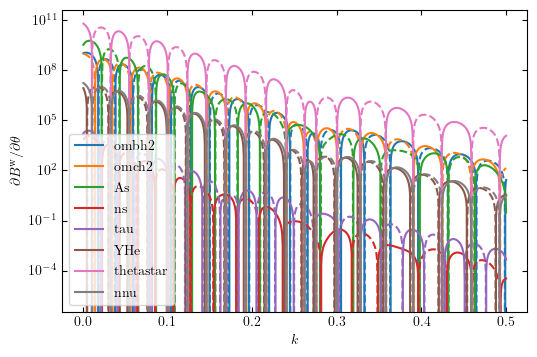

In [13]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_cosmological_parameters((x, svy.pisf*1, np.pi/2), coordinate='child18',
                wiggle_only=True) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.semilogy(kh, dps[:,i], label=l)
    plt.plot(kh, -dps[:,i], c=pl[0].get_color(), ls='--')

plt.ylabel(r'$\partial B^{\rm w}/\partial \theta$')
plt.xlabel('$k$')
plt.legend()

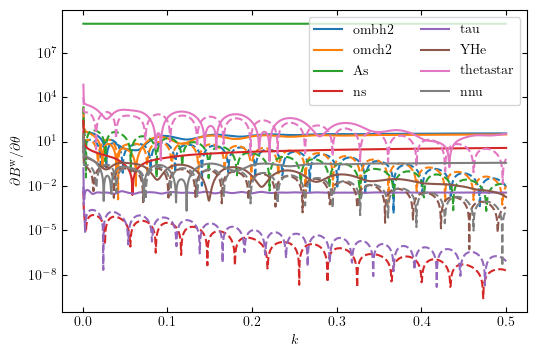

In [40]:
kh = np.linspace(0.001, .5, num=1000)

xx = 2
yy = 0.0001

dps = np.array([svy.bispectrum_derivative_cosmological_parameters((x, svy.pisf*xx, np.pi*yy), coordinate='child18',
                wiggle_only=False)/svy.bispectrum((x, svy.pisf*xx, np.pi*yy), coordinate='child18',) for x in kh])
dpws = np.array([svy.bispectrum_derivative_cosmological_parameters((x, svy.pisf*xx, np.pi*yy), coordinate='child18',
                wiggle_only=True)/svy.bispectrum((x, svy.pisf*xx, np.pi*yy), coordinate='child18',) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.semilogy(kh, np.abs(dps[:,i]), label=l)
    plt.semilogy(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())

plt.ylabel(r'$\partial B^{\rm w}/\partial \theta$')
plt.xlabel('$k$')
plt.legend(ncol=2)

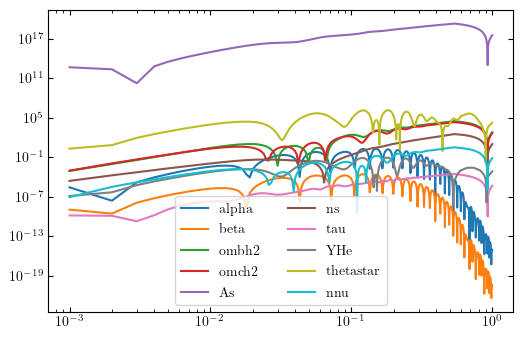

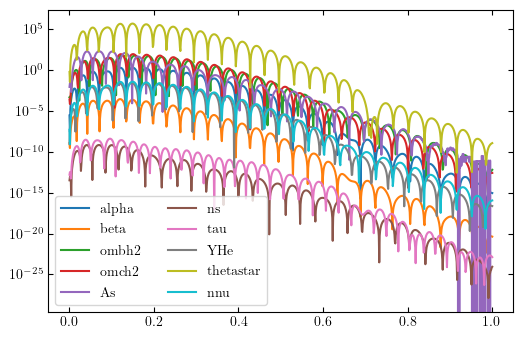

In [22]:
kh = np.linspace(0.001, 1, num=1000)

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=False, k_max_bi=3)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=True, k_max_bi=3)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

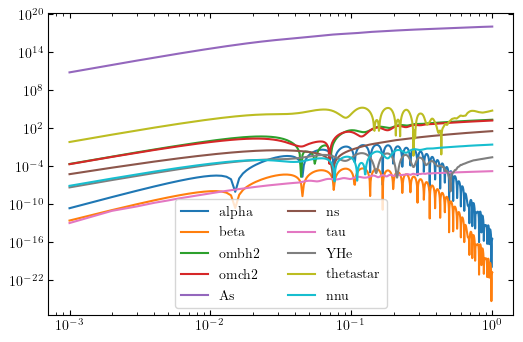

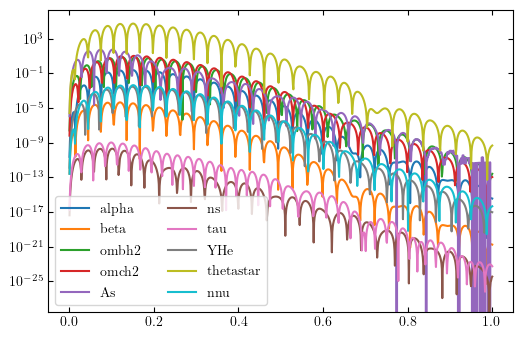

In [23]:
kh = np.linspace(0.001, 1, num=1000)
k1 = 0.01

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, x, x, 0, 0), 0, coordinate='cartesian',wiggle_only=False, k_max_bi=3)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, x, x, 0, 0), 0, coordinate='cartesian',wiggle_only=True, k_max_bi=3)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

No handles with labels found to put in legend.


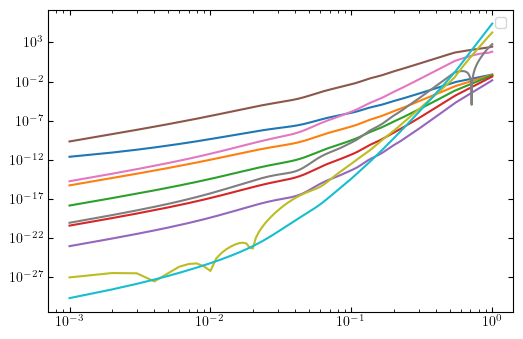

No handles with labels found to put in legend.


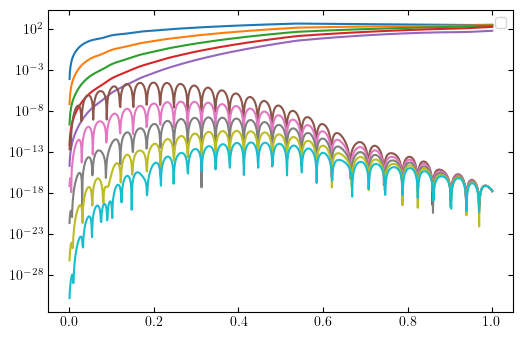

In [16]:
kh = np.linspace(0.001, 1, num=1000)

for i in range(13, 23):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=False, k_max_bi=3)[i, i] for x in kh]
    pl = plt.loglog(kh, dp)    
plt.legend(ncol=2)
plt.show()

for i in range(13, 23):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=True, k_max_bi=3)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp)    
plt.legend(ncol=2)
plt.show()

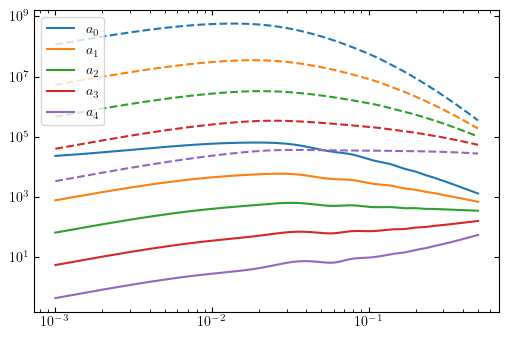

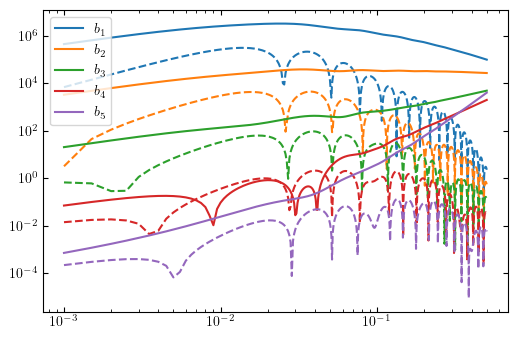

In [17]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_polynomial((x, 0.1, 1), coordinate='child18') for x in kh])
dpws = np.array([svy.bispectrum_derivative_polynomial((x, 0.1, 1), coordinate='child18',
                                                                  wiggle_only=True) for x in kh])
a = svy.polynomial_parameters['a']
b = svy.polynomial_parameters['b']
for i, l in zip(range(len(a)), a):
    pl = plt.loglog(kh, np.abs(dps[:,i]), label='$a_{%d}$'%l)
    plt.loglog(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

for i, l in zip(range(len(a), len(a)+len(b)), b):
    pl = plt.loglog(kh, np.abs(dps[:,i]), label='$b_{%d}$'%l)
    plt.loglog(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

In [53]:
svy.update_survey_setups(
                         survey_geometrics={'f_sky': 0.5,'N_g': 1e100,'z_min': 0.1,'z_max': 4.0,'dz': 0.1,'Sigma_0': 16.6,'reconstruction_rate': 0.5,'b_0': 0.95,'survey_type':'spectroscopic','sigma8_0': 0.9,},
                         )

In [15]:
%timeit svy.integrand_bs((0.01, 0.1, 1, 0, 0), 0, coordinate='child18')

3.85 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
fs = svy.get_bispectrum_fisher_matrix()

In [76]:
fs.slice(['alpha', 'beta'], exclude=True).constraints()[1]['nnu']

0.20155122937596187

In [77]:
sb2sn(fs.slice(['thetastar', 'nnu'], exclude=True).constraints()[1]['beta'])

0.6704678413092431

In [82]:
import h5py
with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)

Removed no burn in
Removed no burn in


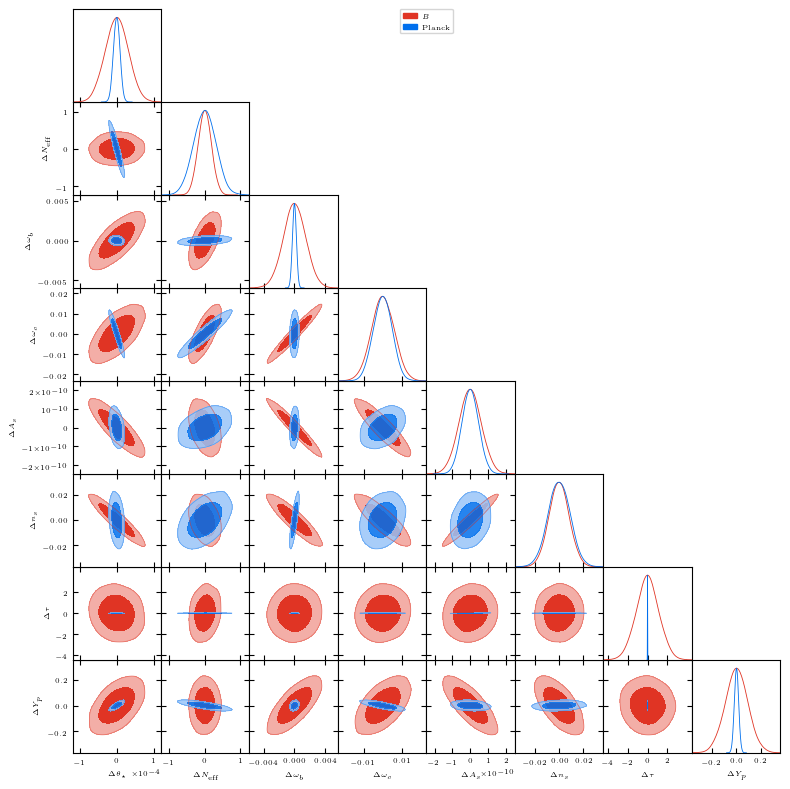

In [96]:
reload(fm)
keys = ['thetastar', 'nnu', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe']
labels =  [r'$\Delta\theta_\star$', r'$\Delta N_{\rm eff}$', r'$\Delta\omega_b$', r'$\Delta\omega_c$', 
           r'$\Delta A_s$', r'$\Delta n_s$', r'$\Delta\tau$', r'$\Delta Y_p$']
fm.triangle_plot([fs, cmb_fisher], keys=keys, fisher_labels=['$B$', 'Planck'], parameter_labels=labels)

In [71]:
with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)
fs.slice(['alpha', 'beta'], exclude=True).merge(cmb_fisher).constraints()[1]['nnu']

0.05215719970354141

In [75]:
with h5py.File('planck_cmb_fisher.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)
sb2sn(fs.slice(['thetastar', 'nnu'], exclude=True).merge(cmb_fisher).constraints()[1]['beta'])

0.06406030297083447

## Survey results

In [45]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy
import h5py

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

import fisher_matrix as fm
import defaults as df
reload(df)

<module 'defaults' from 'C:\\Users\\yanlo\\Dropbox\\galaxy_survey\\defaults.py'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

In [52]:
dfs = df.defaults()

In [51]:
svy = gs.survey()

Text(0, 0.5, '$r(z)$')

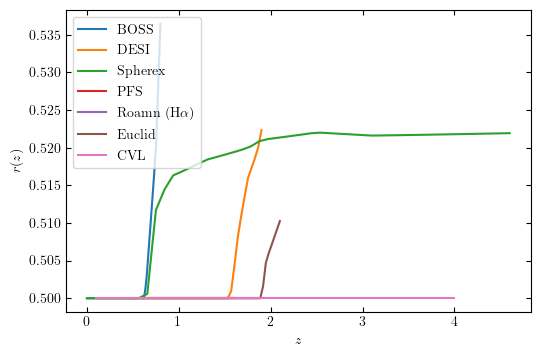

In [56]:
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid, dfs.cvl]
for survey in surveys:
    svy.update_survey_setups(survey_geometrics=survey)
    lbl = survey['name']
    zs = np.linspace(svy.z_min, svy.z_max)
    rs = [svy.reconstruction_rate(z) for z in zs]
    plt.plot(zs, rs, label=lbl)
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$r(z)$')

In [5]:
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid, dfs.cvl]

with h5py.File("survey_fisher_matrix.hdf5", "w") as f:
    for survey in surveys:
        svy.update_survey_setups(survey_geometrics=survey)
        key_svy = survey['short_name']
        print(key_svy, end='\t')
        if key_svy not in list(f.keys()):
            group_svy = f.create_group(key_svy)
            group_svy.attrs['zmax'] = svy.z_max
        else:
            group_svy = f[key_svy]
        for x, l in zip([True, False], ['w', '']):
            if x:
                regions=[{'k_min': 0.01,'k_max': 0.5,'mu_min': -1.0,'mu_max': 1.0}]
            else:
                regions=[{'k_min': 0.01,'k_max': 0.2,'mu_min': -1.0,'mu_max': 1.0}]
            fsp = svy.get_power_spectrum_fisher_matrix(regions=regions, wiggle_only=x, div_mu=50)
            fsb = svy.get_bispectrum_fisher_matrix(wiggle_only=x)
            
            key_fs = 'P'+l
            if key_fs not in list(group_svy.keys()):
                group_fs = group_svy.create_group(key_fs)
            fsp.write_hdf5(group_fs)
            
            key_fs = 'B'+l
            if key_fs not in list(group_svy.keys()):
                group_fs = group_svy.create_group(key_fs)
            fsb.write_hdf5(group_fs)

boss	desi	spherex	pfs	roman	euclid	cvl	

In [4]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')
# CMB+LSS

print('cmb', end='\t')
sb = cmb_fisher.constraints()[1]['nnu']
print('%8.3f (C)'%(sb), end='\n')
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in group_svy.keys():
            fs = fm.read_hdf5(group_svy[fs_key])
            sb = fs.slice(['alpha', 'beta',], exclude=True).constraints()[1]['nnu']
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = fs.merge(cmb_fisher).slice(['alpha', 'beta', ], exclude=True).constraints()[1]['nnu']
            print('%.3f (C+%s)'%(sb, fs_key), end=' ')
        print('')

cmb	   0.317 (C)
boss	   6.283 (B) 0.259 (C+B) 4912.038 (Bw) 0.267 (C+Bw)    7.973 (P) 0.279 (C+P)  111.606 (Pw) 0.293 (C+Pw) 
cvl	   0.402 (B) 0.057 (C+B)  363.310 (Bw) 0.056 (C+Bw)    0.812 (P) 0.124 (C+P)    1.420 (Pw) 0.122 (C+Pw) 
desi	   1.502 (B) 0.134 (C+B) 1259.316 (Bw) 0.140 (C+Bw)    1.742 (P) 0.172 (C+P)   17.152 (Pw) 0.241 (C+Pw) 
euclid	   1.135 (B) 0.113 (C+B)  975.573 (Bw) 0.115 (C+Bw)    1.352 (P) 0.150 (C+P)    9.834 (Pw) 0.222 (C+Pw) 
pfs	   4.422 (B) 0.233 (C+B) 3776.769 (Bw) 0.247 (C+Bw)    5.386 (P) 0.274 (C+P)   53.897 (Pw) 0.290 (C+Pw) 
roman	   3.211 (B) 0.203 (C+B) 2737.295 (Bw) 0.221 (C+Bw)    4.048 (P) 0.255 (C+P)   30.042 (Pw) 0.279 (C+Pw) 
spherex	   2.591 (B) 0.179 (C+B) 2013.440 (Bw) 0.198 (C+Bw)    2.652 (P) 0.210 (C+P)   24.913 (Pw) 0.261 (C+Pw) 


In [7]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher.hdf5')
# CMB + LSS (phase shift)

print('cmb', end='\t')
sb = df.sb2sn_full(cmb_fisher.constraints()[1]['beta'])
print('%8.3f (C)'%(sb), end='\n')
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in group_svy.keys():
            fs = fm.read_hdf5(group_svy[fs_key]).slice(['nnu', 'thetastar'], exclude=True)
            sb = df.sb2sn_full(fs.constraints()[1]['beta'])
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = df.sb2sn_full(fs.merge(cmb_fisher).constraints()[1]['beta'])
            print('%.3f (C+%s)'%(sb, fs_key), end=' ')
        print('')

cmb	   0.305 (C)
boss	   4.673 (B) 0.112 (C+B)    6.762 (Bw) 0.133 (C+Bw)    5.336 (P) 0.171 (C+P)    5.670 (Pw) 0.154 (C+Pw) 
cvl	   0.756 (B) 0.067 (C+B)    3.121 (Bw) 0.090 (C+Bw)    2.808 (P) 0.115 (C+P)    1.457 (Pw) 0.108 (C+Pw) 
desi	   2.181 (B) 0.082 (C+B)    5.324 (Bw) 0.115 (C+Bw)    3.105 (P) 0.118 (C+P)    3.433 (Pw) 0.119 (C+Pw) 
euclid	   1.789 (B) 0.079 (C+B)    4.915 (Bw) 0.111 (C+Bw)    2.729 (P) 0.113 (C+P)    2.983 (Pw) 0.117 (C+Pw) 
pfs	   4.092 (B) 0.101 (C+B)    6.566 (Bw) 0.128 (C+Bw)    5.061 (P) 0.171 (C+P)    5.366 (Pw) 0.149 (C+Pw) 
roman	   3.515 (B) 0.095 (C+B)    6.296 (Bw) 0.123 (C+Bw)    4.712 (P) 0.151 (C+P)    4.901 (Pw) 0.132 (C+Pw) 
spherex	   3.061 (B) 0.091 (C+B)    5.994 (Bw) 0.119 (C+Bw)    3.779 (P) 0.126 (C+P)    4.023 (Pw) 0.122 (C+Pw) 


In [8]:
ap = dfs.alpha_prior
# alpha prior + LSS
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in group_svy.keys():
            fs = fm.read_hdf5(group_svy[fs_key]).slice(['nnu', 'thetastar'], exclude=True)
            sb = df.sb2sn_full(fs.constraints()[1]['beta'])
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = df.sb2sn_full(fs.merge(ap).constraints()[1]['beta'])
            print('%.3f (a+%s)'%(sb, fs_key), end=' ')
        print('')

boss	   4.673 (B) 4.060 (a+B)    6.762 (Bw) 5.391 (a+Bw)    5.336 (P) 5.046 (a+P)    5.670 (Pw) 5.613 (a+Pw) 
cvl	   0.756 (B) 0.691 (a+B)    3.121 (Bw) 1.154 (a+Bw)    2.808 (P) 2.113 (a+P)    1.457 (Pw) 1.456 (a+Pw) 
desi	   2.181 (B) 1.760 (a+B)    5.324 (Bw) 2.934 (a+Bw)    3.105 (P) 2.682 (a+P)    3.433 (Pw) 3.387 (a+Pw) 
euclid	   1.789 (B) 1.457 (a+B)    4.915 (Bw) 2.481 (a+Bw)    2.729 (P) 2.336 (a+P)    2.983 (Pw) 2.950 (a+Pw) 
pfs	   4.092 (B) 3.445 (a+B)    6.566 (Bw) 4.894 (a+Bw)    5.061 (P) 4.636 (a+P)    5.366 (Pw) 5.318 (a+Pw) 
roman	   3.515 (B) 2.894 (a+B)    6.296 (Bw) 4.358 (a+Bw)    4.712 (P) 4.119 (a+P)    4.901 (Pw) 4.866 (a+Pw) 
spherex	   3.061 (B) 2.511 (a+B)    5.994 (Bw) 3.878 (a+Bw)    3.779 (P) 3.286 (a+P)    4.023 (Pw) 3.992 (a+Pw) 


boss	   3.749 (Bw) 2.170 (a+Bw)    4.076 (Pw) 2.554 (a+Pw) 
cvl	   0.542 (Bw) 0.530 (a+Bw)    0.559 (Pw) 0.553 (a+Pw) 
desi	   1.559 (Bw) 1.303 (a+Bw)    1.796 (Pw) 1.544 (a+Pw) 
euclid	   1.275 (Bw) 1.127 (a+Bw)    1.458 (Pw) 1.326 (a+Pw) 
pfs	   3.302 (Bw) 1.997 (a+Bw)    3.636 (Pw) 2.394 (a+Pw) 
roman	   2.732 (Bw) 1.808 (a+Bw)    3.060 (Pw) 2.192 (a+Pw) 
spherex	   2.191 (Bw) 1.613 (a+Bw)    2.332 (Pw) 1.836 (a+Pw) 


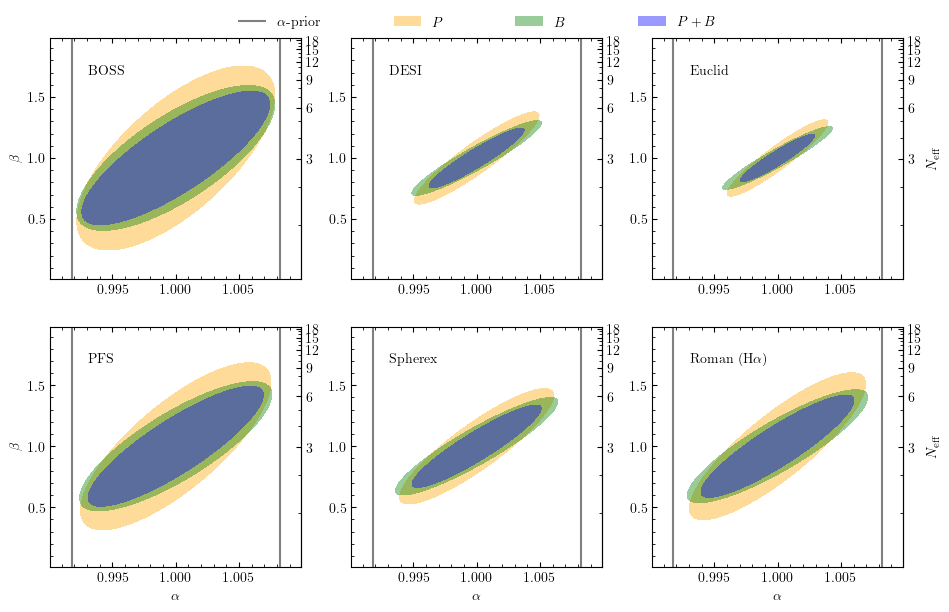

In [44]:
ap = dfs.alpha_prior
# alpha prior + LSS (alpha, beta only)
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in ['Bw', 'Pw']:
            #fs = fm.read_hdf5(group_svy[fs_key]).slice(['nnu', 'thetastar'], exclude=True)
            fs = fm.read_hdf5(group_svy[fs_key]).slice(['alpha', 'beta'])
            sb = df.sb2sn_full(fs.constraints()[1]['beta'])
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = df.sb2sn_full(fs.merge(ap).constraints()[1]['beta'])
            print('%.3f (a+%s)'%(sb, fs_key), end=' ')
        print('')
        
        
        
from scipy import stats        
svys_label = ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman']
svys_title = [r'BOSS', r'DESI', r'Euclid', r'PFS', r'Spherex', r'Roman (H$\alpha$)']
stretch_factor = 1.

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

matplotlib.rcParams['ytick.right'] = False


fig, axs = plt.subplots(2, 3, figsize=(11, 7))
xrange, yrange = 9.9e-3, 0.99
xymean = [1, 1]
x, y = np.mgrid[xymean[0]-xrange:xymean[0]+xrange:.0001, xymean[1]-yrange:xymean[1]+yrange:.01]
pos = np.dstack((x, y))
colors = ['grey', 'orange', 'green', 'blue',]
legends = [r'$\alpha$-prior', r'$P$', r'$B$', r'$P+B$']


with h5py.File('survey_fisher_matrix.hdf5', 'r') as f:
    for r in range(2):
        for i in range(3):
            ax = axs[r, i]
            svy_key = svys_label[r*3+i]
            group_svy = f[svy_key]
            title = svys_title[r*3+i]
            ax.annotate(title, (0.15, 0.85), xycoords='axes fraction')
            #ax.set_title(title)

            fishers = []
            prior = ap
            fishers.append(prior)
            
            fsp = fm.read_hdf5(group_svy['Pw']).slice(['poly', ], fuzzy_filter=True, exclude=True)
            fsb = fm.read_hdf5(group_svy['Bw']).slice(['poly', ], fuzzy_filter=True, exclude=True)
            fspb = fsp.merge(fsb)
            
            fsp = fsp.merge(prior).slice(['nnu', 'YHe'], exclude=True)
            fsb = fsb.merge(prior).slice(['nnu', 'YHe'], exclude=True)
            fspb = fspb.merge(prior).slice(['nnu', 'YHe'], exclude=True)
            #print(fsp.keys)
            fishers.append(fsp)
            fishers.append(fsb)
            fishers.append(fspb)

            j = 0
            nms = []
            lgs = []
            for fisher in fishers:
                #cov = np.linalg.inv(fisher)[:2, :2]
                cov = fisher.slice(['alpha', 'beta']).inverse().slice(['alpha', 'beta']).matrix
                if cov[1, 1] > 1e5:
                    cov[1, 1] = 1e5
                # print(cov)
                rv = stats.multivariate_normal(xymean, cov, allow_singular=True)
                if j == 0:
                    cf = ax.contour(x, y, rv.pdf(pos), levels=[rv.pdf(xymean)*np.e**(-0.5*stretch_factor**2)], colors=[colors[j]])
                    nm, lbl = cf.legend_elements()
                    if r*3+i == 1:
                        nms += nm
                        lgs += [legends[j]]
                else:
                    cf = ax.contourf(x, y, rv.pdf(pos), levels=[rv.pdf(xymean)*np.e**(-0.5*stretch_factor**2), 10086], colors=[colors[j]], alpha=0.4)
                    nm, lbl = cf.legend_elements()
                    if r*3+i == 1:
                        nms += nm
                        lgs += [legends[j]]
#                     if r*3+i == 2 and (j == 2 or j == 3):
#                         nms += nm
#                         lgs += [legends[j]]

                if nms != []:
                    #ax.legend(nms, lgs, ncol=2)  
                    ax.legend(nms, lgs, bbox_to_anchor=(-0.5, 1.05, 2, .1), loc='upper right', mode='expand', ncol=7, frameon=False)

                if j == 0:
                    ax_r = ax.secondary_yaxis("right", functions=(df.b2n, df.n2b))
                    ax_r.yaxis.set_major_locator(MultipleLocator(3))
                    ax_r.yaxis.set_minor_locator(MultipleLocator(1))
                    if i == 2:
                        ax_r.set_ylabel(r'$N_{\rm eff}$')
#                     else:
#                         ax_r.set_yticks([])

                j += 1
            
                ax.xaxis.set_major_locator(MultipleLocator(0.005))
                ax.xaxis.set_minor_locator(MultipleLocator(0.001))
                ax.yaxis.set_major_locator(MultipleLocator(0.5))
                ax.yaxis.set_minor_locator(MultipleLocator(0.1))
                
            if i == 0:
                ax.set_ylabel(r'$\beta$')
            if r == 1:
                ax.set_xlabel(r'$\alpha$')
            
plt.savefig('plots/contours-alpha-beta.pdf', bbox_inches='tight')
matplotlib.rcParams['ytick.right'] = True
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in


C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:139: RuntimeWarning: covariance is not positive-semidefinite.
  g = plots.get_subplot_plotter(width_inch=6)


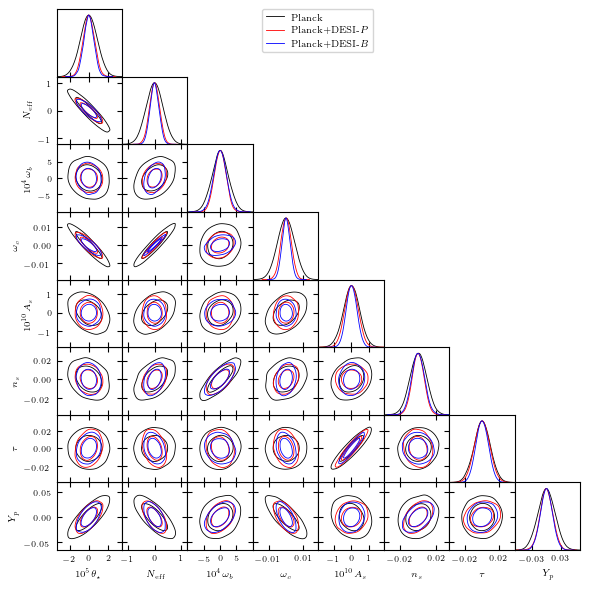

Removed no burn in
Removed no burn in
Removed no burn in


C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:139: RuntimeWarning: covariance is not positive-semidefinite.
  g = plots.get_subplot_plotter(width_inch=6)


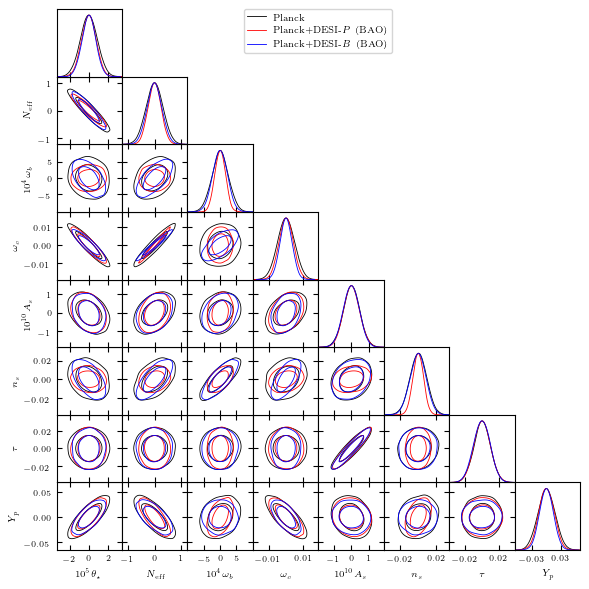

Removed no burn in
Removed no burn in
Removed no burn in


C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:139: RuntimeWarning: covariance is not positive-semidefinite.
  g = plots.get_subplot_plotter(width_inch=6)


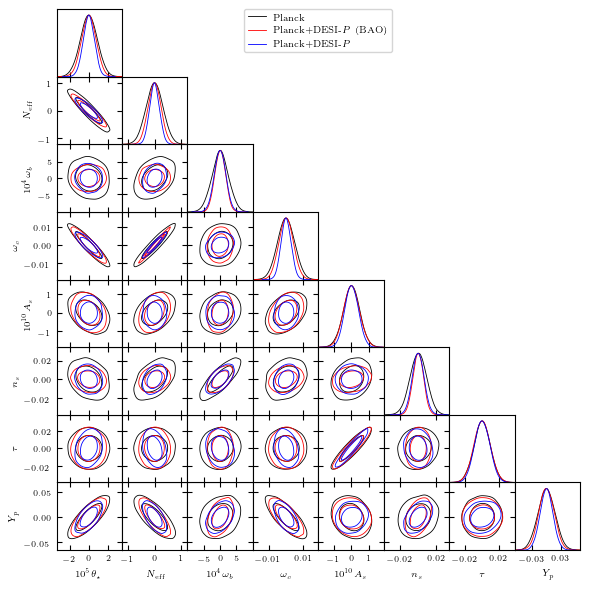

In [49]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')

with h5py.File("survey_fisher_matrix.hdf5", 'r') as f:
    fsb = fm.read_hdf5(f['desi']['B'])
    fsbw = fm.read_hdf5(f['desi']['Bw'])
    fsp = fm.read_hdf5(f['desi']['P'])
    fspw = fm.read_hdf5(f['desi']['Pw'])
    
    keys = ['thetastar', 'nnu', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe']
    labels =  [r'$10^5\theta_\star$', r'$ N_{\rm eff}$', r'$10^4\omega_b$', r'$\omega_c$', 
           r'$ 10^{10}A_s$', r'$ n_s$', r'$\tau$', r'$ Y_p$']
    norms = {'thetastar': 1e5,'ombh2': 1e4,'As': 1e10,}
    
    #
    fm.triangle_plot([cmb_fisher, fsp.merge(cmb_fisher), fsb.merge(cmb_fisher), ], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$', 'Planck+DESI-$B$', ], 
                 parameter_labels=labels, norms=norms, marginalize=True)
    plt.savefig('fisher-matrix-broadband-corner.pdf', bbox_inches='tight')
    plt.show()
    
    #
    fm.triangle_plot([cmb_fisher, cmb_fisher.merge(fspw), cmb_fisher.merge(fsbw)], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$ (BAO)', 'Planck+DESI-$B$ (BAO)', ], 
                 parameter_labels=labels, norms=norms, marginalize=True)
    plt.savefig('fisher-matrix-wiggle-corner.pdf', bbox_inches='tight')
    plt.show()
    
    #
    fm.triangle_plot([cmb_fisher, cmb_fisher.merge(fspw), cmb_fisher.merge(fsp)], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$ (BAO)', 'Planck+DESI-$P$', ], 
                 parameter_labels=labels, norms=norms, marginalize=True)
#     plt.savefig('fisher-matrix-wiggle-corner.pdf', bbox_inches='tight')
    plt.show()

['thetastar', 'nnu', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe']


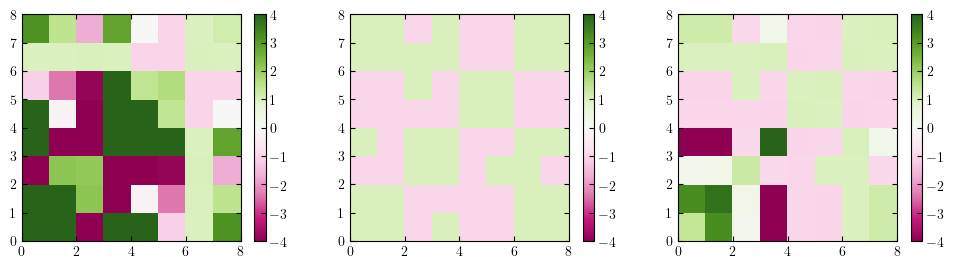

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
i = 0
print(keys)
for fs in [cmb_fisher.merge(fsb), cmb_fisher, cmb_fisher.merge(fsbw)]:
    matrix0 = cmb_fisher.slice(keys).matrix
    z = fs.slice(keys).matrix/np.abs(matrix0)
    ax = axs[i]
    c = ax.pcolormesh(z, vmax=4, vmin=-4, cmap='PiYG')
    fig.colorbar(c, ax=ax)
    i += 1

### Kmax dependence

In [11]:
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid,]
ks = np.linspace(0.02, 0.3, num=29)

with h5py.File("survey_fisher_matrix_kmax.hdf5", "w") as f:
    for survey in surveys:
        svy.update_survey_setups(survey_geometrics=survey)
        key_svy = survey['short_name']
        print(key_svy, end='\t')
        if key_svy not in list(f.keys()):
            group_svy = f.create_group(key_svy)
            group_svy.attrs['zmax'] = svy.z_max
        else:
            group_svy = f[key_svy]
        for i in tqdm(range(len(ks))):
            kmax = ks[i]
            key_k = '%d'%i
            if key_k not in list(group_svy.keys()):
                group_k = group_svy.create_group(key_k)
                group_k.attrs['kmax'] = kmax
            else:
                group_k = group_svy[key_k]
            
            for x, l in zip([True, False], ['w', '']):
                fsp = svy.get_power_spectrum_fisher_matrix(wiggle_only=x, div_k = int((kmax-0.01)/0.0025),
                            regions=[{'k_min': 0.01,'k_max': kmax,'mu_min': -1.0,'mu_max': 1.0}])
                div = int(max(6, (kmax)/0.045))
                print(div, end='')
                fsb = svy.get_bispectrum_fisher_matrix(wiggle_only=x,
                            regions = [{'coordinate': 'cartesian',\
                                            'mu_opt': True,\
                                            'bounds': ((0.01, kmax),(0.01, kmax),(0.01, kmax),(0, 1),(0, 6.283185307179586)),\
                                            'divideby': 'num',\
                                            'divs': (div, div, div, div, div)}], verbose=True)

                key_fs = 'P'+l
                if key_fs not in list(group_k.keys()):
                    group_fs = group_k.create_group(key_fs)
                fsp.write_hdf5(group_fs)

                key_fs = 'B'+l
                if key_fs not in list(group_k.keys()):
                    group_fs = group_k.create_group(key_fs)
                fsb.write_hdf5(group_fs)
                print('+'+l, end='')

boss	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+desi	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+pfs	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+roman	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>

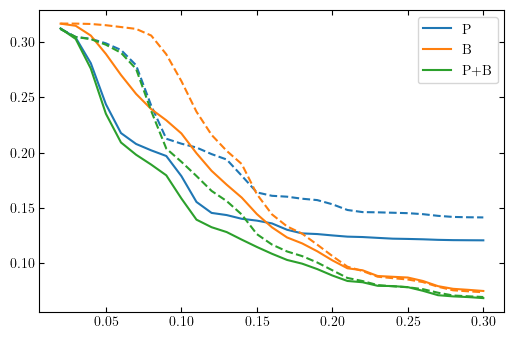

In [58]:
import h5py
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')
reload(fm)
ks = np.linspace(0.02, 0.3, num=29)

polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['a5', 'b4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]

polys_ex = ['poly_', 'bias']
polys_ex_w = ['poly_', 'bias']

sns = []
with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    for i in range(len(ks)):
        temp = []
        kmax = ks[i]
        key_k = str(i)
        fv = f['desi']
        fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        for fs in [fsp, fspw, fsb, fsbw, fsp.merge(fsb), fspw.merge(fsbw)]:
            fmt = fs.merge(cmb_fisher).slice(['alpha', 'beta',], exclude=True)
            sn = fmt.constraints()[1]['nnu']
            #print(fmt.keys)
            temp.append(sn)
        sns.append(temp)
        
sns = np.array(sns)

for j, l in zip(range(3), ['P', 'B', 'P+B']):
    k = 0+j*2
    pl = plt.plot(ks, sns[:,k], label=l)
    k = 1+j*2
    pl = plt.plot(ks, sns[:,k], ls='--', c=pl[0].get_color())
    
plt.legend()
plt.show()

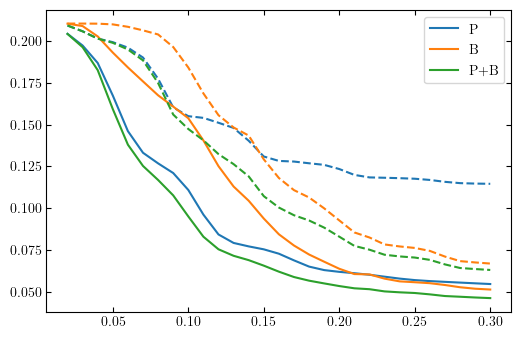

In [13]:
sns = []
with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    for i in range(len(ks)):
        temp = []
        kmax = ks[i]
        key_k = str(i)
        fv = f['desi']
        fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        for fs in [fsp, fspw, fsb, fsbw, fsp.merge(fsb), fspw.merge(fsbw)]:
            sn = fs.merge(cmb_fisher).slice(['alpha', 'beta', 'YHe'], exclude=True).constraints()[1]['nnu']
            temp.append(sn)
        sns.append(temp)
        
sns = np.array(sns)

for j, l in zip(range(3), ['P', 'B', 'P+B']):
    k = 0+j*2
    pl = plt.plot(ks, sns[:,k], label=l)
    k = 1+j*2
    pl = plt.plot(ks, sns[:,k], ls='--', c=pl[0].get_color())
    
plt.legend()
plt.show()

In [60]:
def reshape_lines(s):
    for i in range(len(s)-1):
        k = len(s)-i-1
        if s[k-1]<s[k]:
            s[k-1] = s[k]
        if s[k-1]>cmb_fisher.constraints()[1]['nnu']:
            s[k-1] = cmb_fisher.constraints()[1]['nnu']
    return s

boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid

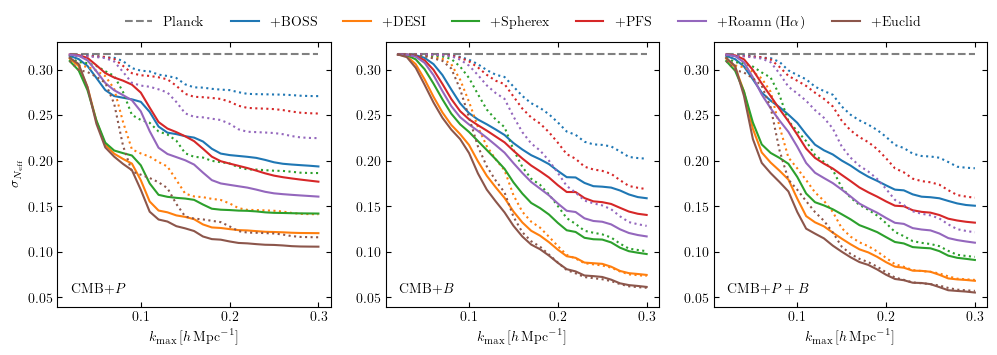

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), sharex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.07)
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid,]
# surveys = [dfs.boss, dfs.desi]
#surveys = [dfs.euclid]
cmb_survey = 'planck'
#cmb_survey = 'cmb_s3'
#cmb_survey = 'cmb_s4'
cmb_fisher = fm.read_hdf5('%s_cmb_fisher_original.hdf5'%cmb_survey)

cps_ex = ['alpha', 'beta',]



polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['a4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]

polys_ex = ['poly', 'bias']
polys_ex_w = ['poly', 'bias']

if cmb_survey == 'planck':
    cmb_label = 'Planck'
    ymin, ymax = 0.04, 0.33
if cmb_survey == 'cmb_s3':
    cmb_label = 'CMB-S3'
    ymin, ymax = 0.03, 0.125
    
if cmb_survey == 'cmb_s4':
    cmb_label = 'CMB-S4'
    ymin, ymax = 0.025, 0.087

ax = axs[0]
ax.plot(ks, np.repeat(cmb_fisher.slice(cps_ex, exclude=True).constraints()[1]['nnu'], len(ks)), ls='--', label=cmb_label, c='grey')

with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    for survey in surveys:
        sns = []
        key_svy = survey['short_name']
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            for fs in [fsp, fspw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        if key_svy in ['boss', 'desi']:
            label = '+'+survey['name']
        else:
            label = None
            label = '+'+survey['name']
        pl = ax.plot(ks, reshape_lines(sns[:,0]), label=label)
        ax.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
ax.legend(bbox_to_anchor=(0.2, 1.05, 3, .1), loc='upper right', mode='expand', ncol=7, prop={'size': 10}, frameon=False)
ax.annotate(r'CMB+$P$', (0.05, 0.05), xycoords='axes fraction')
ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
ax.set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')
ax.set_ylim(ymin, ymax)

ax = axs[1]
ax.plot(ks, np.repeat(cmb_fisher.slice(cps_ex, exclude=True).constraints()[1]['nnu'], len(ks)), ls='--', c='grey')

with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    for survey in surveys:
        sns = []
        key_svy = survey['short_name']
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            for fs in [fsb, fsbw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        if key_svy in ['euclid', 'pfs']:
            label = '+'+survey['name']
        else:
            label = None
        pl = ax.plot(ks, reshape_lines(sns[:,0]), label=label)
        ax.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
#ax.legend()
ax.annotate(r'CMB+$B$', (0.05, 0.05), xycoords='axes fraction')
#ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
ax.set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')
ax.set_ylim(ymin, ymax)

ax = axs[2]
ax.plot(ks, np.repeat(cmb_fisher.slice(cps_ex, exclude=True).constraints()[1]['nnu'], len(ks)), ls='--', c='grey')

with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    for survey in surveys:
        sns = []
        key_svy = survey['short_name']
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            for fs in [fsp.merge(fsb), fspw.merge(fsbw)]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        if key_svy in ['roman', 'spherex']:
            label = '+'+survey['name']
        else:
            label = None
        pl = ax.plot(ks, reshape_lines(sns[:,0]), label=label)
        ax.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
#ax.legend()
ax.annotate(r'CMB+$P+B$', (0.05, 0.05), xycoords='axes fraction')
#ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
ax.set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')
ax.set_ylim(ymin, ymax)


plt.savefig('plots/kmax_dependence-%s.pdf'%cmb_survey, bbox_inches='tight')
plt.show()

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

/home/yanlong/Dropbox/galaxy_survey/fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

/home/yanlong/Dropbox/galaxy_survey/fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

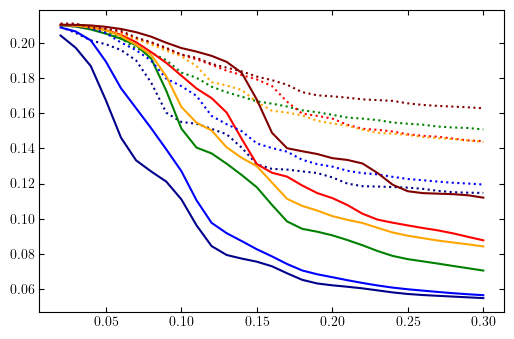

In [18]:
poly_exs = [
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b3', 'b4', 'b5'],
    ['b2', 'b3', 'b4', 'b5'],
    ['a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a3', 'a4', 'b2', 'b3', 'b4', 'b5'],
    [],
]
cps_ex = ['alpha', 'beta', 'YHe']
cs = ['darkblue', 'green', 'red', 'blue', 'orange', 'maroon']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')


with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    survey = dfs.desi
    key_svy = survey['short_name']
    for poly_ex, c in zip(poly_exs, cs):
        sns = []
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            for fs in [fsp, fspw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        pl = plt.plot(ks, reshape_lines(sns[:,0]), label=label, c=c)
        plt.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
#ax.legend()

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

/home/yanlong/Dropbox/galaxy_survey/fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

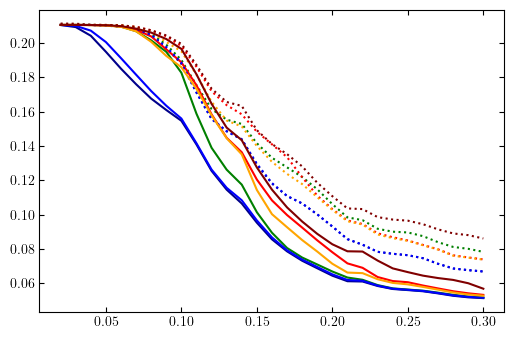

In [17]:
poly_exs = [
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b3', 'b4', 'b5'],
    ['b2', 'b3', 'b4', 'b5'],
    ['a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a3', 'a4', 'b2', 'b3', 'b4', 'b5'],
    [],
]
cps_ex = ['alpha', 'beta', 'YHe']
cs = ['darkblue', 'green', 'red', 'blue', 'orange', 'maroon']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')


with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    survey = dfs.desi
    key_svy = survey['short_name']
    for poly_ex, c in zip(poly_exs, cs):
        sns = []
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsp = fm.read_hdf5(fv[key_k]['B']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Bw']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            for fs in [fsp, fspw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        pl = plt.plot(ks, reshape_lines(sns[:,0]), label=label, c=c)
        plt.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
#ax.legend()